In [14]:
import os
import cv2
import numpy as np
import random
import keras

from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

# Image with Mask

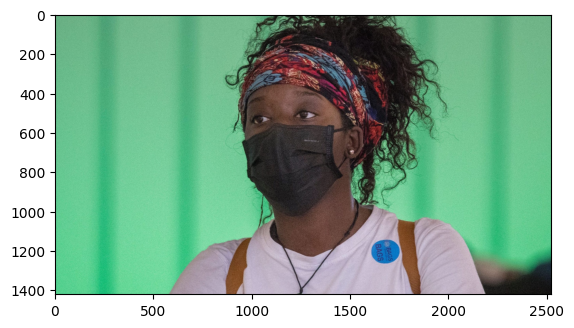

In [15]:
images_withMask = os.listdir("./Dataset/Train/Mask")
sample_img_withMask = random.choice(images_withMask)
image = load_img("./Dataset/Train/Mask/"+sample_img_withMask)
plt.imshow(image)

# Image without Mask

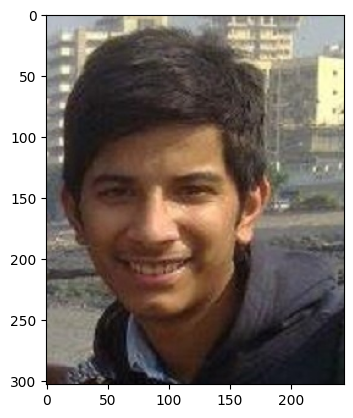

In [16]:
images_withoutMask = os.listdir("./Dataset/Train/Non Mask")
sample_img_withoutMask = random.choice(images_withoutMask)
image = load_img("./Dataset/Train/Non Mask/"+sample_img_withoutMask)
plt.imshow(image)

In [17]:
# define constant
img_width=224
img_height=224

# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 50
BS = 32
train_data_dir="./Dataset/Train"
test_data_dir="./Dataset/Validation"

In [18]:
all_train_imagePaths = list(paths.list_images(train_data_dir))
all_test_imagePaths = list(paths.list_images(test_data_dir))
train_data = []
train_labels = []
test_data = []
test_labels = []

In [19]:
# loop over the image paths
for imagePath in all_train_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	train_data.append(image)
	train_labels.append(label)

In [20]:
# loop over the image paths
for imagePath in all_test_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))

	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	test_data.append(image)
	test_labels.append(label)

In [21]:
def convert_data_labels(data,labels):
  # convert the data and labels to NumPy arrays
  data = np.array(data, dtype="float32")
  labels = np.array(labels)

  # perform one-hot encoding on the labels
  lb = LabelBinarizer()
  labels = lb.fit_transform(labels)
  labels = to_categorical(labels)
  return  data,labels

In [22]:
train_data,train_labels = convert_data_labels(train_data,train_labels)
test_data,test_labels = convert_data_labels(test_data,test_labels)

In [23]:
print("==================================")
print("Size of train dataset : ",train_data.shape[0])
print("==================================")
print("Size of test dataset : ",test_data.shape[0])
print("==================================")

Size of train dataset :  600
Size of test dataset :  306


In [24]:
# train datagen
train_datagen = ImageDataGenerator(
                  rotation_range=20,
                  zoom_range=0.15,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=0.15,
                  horizontal_flip=True,
                  fill_mode="nearest")

train_generator = train_datagen.flow(train_data, train_labels, batch_size=BS)

In [25]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

C:\Users\durga\AppData\Local\Temp\ipykernel_1716\2099937604.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
# construct the head of the model that will be placed on top of the the base model
headModel = mobilenet.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [27]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=mobilenet.input, outputs=headModel)

In [28]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Done !!")

[INFO] compiling model...
Done !!


c:\Users\durga\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [29]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in mobilenet.layers:
	layer.trainable = False

In [30]:
# this code is to show how much time required to train the model using different algorithms
from datetime import datetime
def timer(start_time= None):
  if not start_time:
    start_time=datetime.now()
    return start_time
  elif start_time:
    thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
    tmin,tsec=divmod(temp_sec,60)
    print('\n Time taken: %i hours %i minutes and %s seconds. '% (thour,tmin,round(tsec,2)))

# Model Change 

In [ ]:
# checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
# # history=model.fit(train_data,train_target,epochs=100,callbacks=[checkpoint],validation_split=0.2)
# EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

# ModelCheckPoint
# checkPoint = keras.callbacks.ModelCheckpoint(filepath="/content/sample_data/fmd_model.h5",
#                              monitor='val_loss',
#                              mode='auto',
#                              save_best_only=True,
#                              verbose=1)

# ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# TBoard = tf.keras.callbacks.TensorBoard(log_dir='./logs')

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=/fmd_model.h5

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# EarlyStopping
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    restore_best_weights=True
)

# ModelCheckpoint - Using the .keras extension for compatibility
checkPoint = ModelCheckpoint(
    filepath="/content/sample_data/fmd_model.keras",  # Use .keras extension for latest compatibility
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose=1
)

# ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

# TensorBoard for logging
TBoard = TensorBoard(log_dir='./logs')

# Now, when training the model, include these callbacks in model.fit:
history = model.fit(
    train_data,
    train_labels,
    epochs=100,
    validation_split=0.2,
    callbacks=[earlystop, checkPoint, learning_rate_reduction, TBoard]
)

Epoch 1/100


c:\Users\durga\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4166 - loss: 0.9615
Epoch 1: val_loss improved from inf to 0.91081, saving model to /content/sample_data/fmd_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 489ms/step - accuracy: 0.4226 - loss: 0.9549 - val_accuracy: 0.2417 - val_loss: 0.9108 - learning_rate: 1.0000e-04
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7370 - loss: 0.6126
Epoch 2: val_loss improved from 0.91081 to 0.62818, saving model to /content/sample_data/fmd_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.7401 - loss: 0.6087 - val_accuracy: 0.6750 - val_loss: 0.6282 - learning_rate: 1.0000e-04
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8757 - loss: 0.4252
Epoch 3: val_loss improved from 0.62818 to 0.42609, saving model to /content/sample_data/fmd_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.8772 - loss: 0.4237 - val_accuracy: 0.9167 - val_loss: 0.4261 - learning_rate: 1.0000e-04
Epoc

In [38]:
callbacks = [earlystop , checkPoint, learning_rate_reduction]

In [39]:
start_time=timer(None)
classifier = model.fit(
    train_datagen.flow(train_data, train_labels, batch_size=BS), 
    epochs=EPOCHS,
    validation_data=(test_data,test_labels),
    validation_steps=len(test_data)//BS,
    steps_per_epoch=len(train_data)//BS,
    callbacks=callbacks
)
timer(start_time)

c:\Users\durga\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9897 - loss: 0.0540
Epoch 1: val_loss did not improve from 0.02326
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 815ms/step - accuracy: 0.9897 - loss: 0.0540 - val_accuracy: 0.9706 - val_loss: 0.1050 - learning_rate: 1.0000e-05
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0762 - learning_rate: 1.0000e-05
Epoch 3/50


c:\Users\durga\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
c:\Users\durga\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\durga\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
c:\Users\durga\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWa

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9922 - loss: 0.0451
Epoch 3: val_loss did not improve from 0.02326
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 833ms/step - accuracy: 0.9922 - loss: 0.0454 - val_accuracy: 0.9706 - val_loss: 0.1037 - learning_rate: 1.0000e-05
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.0488 - learning_rate: 1.0000e-05
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.9873 - loss: 0.0590
Epoch 5: val_loss did not improve from 0.02326
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 828ms/step - accuracy: 0.9870 - loss: 0.0592 - val_accuracy: 0.9706 - val_loss: 0.1044 - learning_rate: 1.0000e-05
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0391 - learning_rate: 1.0000e-05
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.9880 - loss: 0.0546
Epoch 7: val_loss did not improve from 0.02326
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 768ms/step - accuracy: 0.9877 - loss: 0.0551 - val_accuracy: 0.97

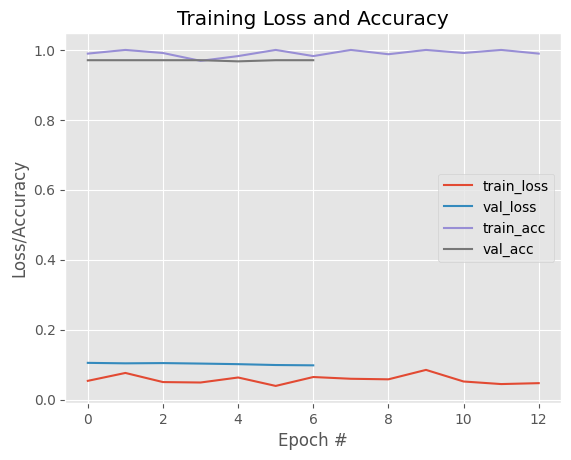

In [40]:
# plot the training loss and accuracy
plt.style.use("ggplot")
N = 10 # epochs number
plt.figure()
plt.plot( classifier.history["loss"], label="train_loss")
plt.plot( classifier.history["val_loss"], label="val_loss")
plt.plot( classifier.history["accuracy"], label="train_acc")
plt.plot( classifier.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

In [41]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(test_data, batch_size=BS)

[INFO] evaluating network...


c:\Users\durga\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 442ms/step


In [42]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [43]:
# check accuracy
val_loss,val_acc = model.evaluate(test_data,test_labels)
print("=======================================================")
print("Accuracy is : ",val_acc)
print("=======================================================")
print("Loss is : ",val_loss)
print("=======================================================")

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - accuracy: 0.9808 - loss: 0.0699
Accuracy is :  0.970588207244873
Loss is :  0.1050216481089592


In [44]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       153
           1       0.98      0.96      0.97       153

    accuracy                           0.97       306
   macro avg       0.97      0.97      0.97       306
weighted avg       0.97      0.97      0.97       306



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


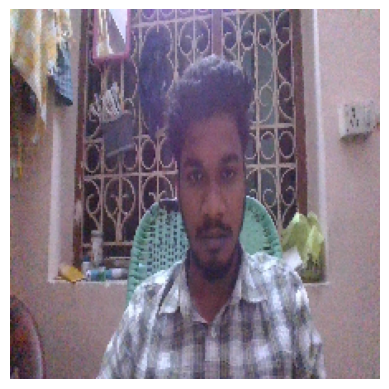

Prediction: No Mask


In [48]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

def predict_mask(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))  # Resize to the input shape expected by the model
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (required by the model)
    img_array = preprocess_input(img_array)  # Preprocess image (same as during training)
    
    # Make a prediction
    prediction = model.predict(img_array)
    
    # Get the predicted class (0 for No Mask, 1 for Mask)
    predicted_class = np.argmax(prediction, axis=1)[0]  # 0 or 1 based on which class has the higher probability
    
    # Display the image and prediction result
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()
    
    if predicted_class == 0:
        print("Prediction: No Mask")
    else:
        print("Prediction: Mask")

# Example usage:
image_path = r'C:\Users\durga\Desktop\FaceMaskDetection\WIN_20241112_18_41_05_Pro.jpg'
  # Replace with your image path
predict_mask(image_path, model)

